# Imports

## Libraries

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
# Standard Library Imports
import datetime
import io
import pickle
import re
import zipfile

# Third-Party Imports
from flaml import AutoML
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna_integration import OptunaSearchCV
import pandas as pd
import requests
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from skrub import TableVectorizer
import xgboost as xgb

## Data

### Provided data

In [4]:
# Import provided data
train = pd.read_parquet("/Users/pierrehaas/bike_counters/data/train.parquet")
test = pd.read_parquet("/Users/pierrehaas/bike_counters/data/final_test.parquet")

### External data

#### Weather data

In [5]:
# Import additionally sourced data

# https://meteo.data.gouv.fr/datasets/donnees-climatologiques-de-base-horaires/
weather = pd.read_csv(
    "/Users/pierrehaas/bike_counters/external_data/weather/H_75_previous-2020-2022.csv.gz",
    parse_dates=["AAAAMMJJHH"],
    date_format="%Y%m%d%H",
    compression="gzip",
    sep=";",
).rename(columns={"AAAAMMJJHH": "date"})

#### Public transport data

In [6]:
# https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/information/
# URLs of the zip files
urls = [
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/files/e6bcf4c994951fc086e31db6819a3448/download/",
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-ferre/files/e35b9ec0a183a8f2c7a8537dd43b124c/download/",
]

# Initialize an empty list to store DataFrames
dfs = []

# File matching pattern
pattern = r"data-rf-202\d/202\d_S\d+_NB_FER\.txt"

# Process each ZIP file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Get a list of all files in the archive and filter matching files
            matching_files = [f for f in z.namelist() if re.match(pattern, f)]

            # Read and concatenate the matching files
            for file in matching_files:
                with z.open(file) as f:
                    # Assuming the files are tab-separated and have a "JOUR" column
                    df = pd.read_csv(f, sep="\t", parse_dates=["JOUR"], dayfirst=True)
                    dfs.append(df)

# Combine all DataFrames
underground_transport = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


# # https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/information/
# # URLs of the zip files
urls = [
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/files/41adcbd4216382c232ced4ccbf60187e/download/",
    "https://data.iledefrance-mobilites.fr/explore/dataset/histo-validations-reseau-surface/files/68cac32e8717f476905a60006a4dca26/download/",
]

# Initialize an empty list to store DataFrames
dfs = []

# File matching pattern
pattern = r"data-rs-202\d/202\d_T\d+_NB_SURFACE\.txt"

# Process each ZIP file
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Get a list of all files in the archive and filter matching files
            matching_files = [f for f in z.namelist() if re.match(pattern, f)]

            # Read and concatenate the matching files
            for file in matching_files:
                with z.open(file) as f:
                    # Assuming the files are tab-separated and have a "JOUR" column
                    df = pd.read_csv(
                        f,
                        sep="\t",
                        parse_dates=["JOUR"],
                        dayfirst=True,
                        encoding="latin1",
                    )
                    dfs.append(df)

# Combine all DataFrames
overground_transport = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

#### Car traffic data

In [7]:
# URLs of the zip files
urls = [
    "https://parisdata.opendatasoft.com/api/datasets/1.0/comptages-routiers-permanents-historique/attachments/opendata_txt_2020_zip/",
    # "https://parisdata.opendatasoft.com/api/datasets/1.0/comptages-routiers-permanents-historique/attachments/opendata_txt_2021_zip/", # This file's compression format is broken, thus I provide a download link below
    "https://www.dropbox.com/scl/fi/sfqzlzpyxcf4yied3yucc/comptage-routier-2021.zip?rlkey=6k6hr3kywl8tvm4ax1qv2nv88&st=ktehiium&dl=1",
]

# Initialize an empty list to store DataFrames
dfs = []

# Process each ZIP file
for i, url in enumerate(urls):
    response = requests.get(url)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Process every file in the archive
            for file in z.namelist():
                # Skip directories and __MACOSX files
                if file.endswith("/") or "__MACOSX" in file:
                    continue
                # For the second URL, ensure files are within "comptage-routier-2021" directory
                if i == 1 and not file.startswith("comptage-routier-2021/"):
                    continue
                with z.open(file) as f:
                    # Assuming the files are semicolon-separated and have a "t_1h" column
                    df = pd.read_csv(f, sep=";", parse_dates=["t_1h"])
                    dfs.append(df)

# Combine all DataFrames
cars_count = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Data preparation | Feature engineering

## Date encoding

In [185]:
def date_encoder(X, col="date"):
    X = X.copy()  # modify a copy of X

    # Encode the date information from the DateOfDeparture columns
    X["year"] = X[col].dt.year
    X["quarter"] = X[col].dt.quarter
    X["month"] = X[col].dt.month
    X["day"] = X[col].dt.day
    X["weekday"] = X[col].dt.weekday + 1
    X["hour"] = X[col].dt.hour
    X["hour_scaled"] = np.cos(2 * np.pi * X["hour"] / 24)

    # Binary variable indicating weekend or not (1=weekend, 0=weekday)
    X["is_weekend"] = (X["weekday"] > 5).astype(int)

    # Binary variable indicating bank holiday or not (1=holiday, 0=not holiday)
    import holidays

    fr_bank_holidays = holidays.FR()  # Get list of FR holidays
    X["is_bank_holiday"] = X[col].apply(lambda x: 1 if x in fr_bank_holidays else 0)

    X = X.copy()  # modify a copy of X

    # Binary variable indicating school holiday or not (1=holiday, 0=not holiday)
    # https://www.data.gouv.fr/fr/datasets/vacances-scolaires-par-zones/
    fr_school_holidays = pd.read_csv(
        "/Users/pierrehaas/bike_counters/external_data/vacances_scolaires_france.csv"
    )[["date", "vacances_zone_c"]]

    # Ensure both DataFrames have a consistent datetime format
    X["date_normalized"] = pd.to_datetime(X[col]).dt.normalize()
    fr_school_holidays["date"] = pd.to_datetime(
        fr_school_holidays["date"]
    ).dt.normalize()

    # Create a dictionary from the holidays dataset for faster lookup
    holiday_mapping = dict(
        zip(fr_school_holidays["date"], fr_school_holidays["vacances_zone_c"])
    )

    # Map the normalized date to the holiday column
    X["is_school_holiday"] = (
        X["date_normalized"].map(holiday_mapping).fillna(0).astype(int)
    )

    # Drop the normalized date column if not needed
    X.drop(columns=["date_normalized"], inplace=True)

    # Finally, return the updated DataFrame
    return X

## Feature engineering on train and test data

In [186]:
def train_test_processing(X_train, X_test):

    def dist_station(X):

        lat_long_station = (
            X[["latitude", "longitude"]]
            - mode(
                X[X["site_name"] == "Totem 73 boulevard de Sébastopol"][
                    ["latitude", "longitude"]
                ]
            )[0]
        )

        # We calculate the distance the previously identified site to all others
        # We call the result the distance to the center since the station is close to the center of Paris
        dist_station = np.linalg.norm(
            lat_long_station,
            axis=1,
        )

        return dist_station

    def covid_features(X):

        # Create a binary variable indicating the presence of a lockdown
        # https://fr.wikipedia.org/wiki/Chronologie_de_la_pand%C3%A9mie_de_Covid-19_en_France
        lockdown_dates = [
            ("2020-10-30", "2020-12-15"),
            ("2021-04-03", "2021-05-03"),
        ]

        X["covid_lockdown"] = 0

        for start, end in lockdown_dates:
            X.loc[(X["date"] >= start) & (X["date"] < end), "covid_lockdown"] = 1

        curfew_dates = [
            ("2020-10-17", "2020-10-30", 21, 6),  # 21h-6h
            ("2020-12-16", "2021-01-15", 20, 6),  # 20h-6h
            ("2021-01-15", "2021-03-19", 19, 6),  # 19h-6h
            ("2021-03-20", "2021-04-03", 18, 6),  # 18h-6h
            ("2021-05-03", "2021-06-09", 19, 6),  # 19h-6h
            ("2021-06-09", "2021-06-20", 23, 6),  # 23h-6h
        ]

        X["covid_curfew"] = 0

        for start_date, end_date, start_hour, end_hour in curfew_dates:
            X.loc[
                (X["date"] >= start_date)
                & (X["date"] < end_date)
                & (X["hour"] >= start_hour)
                & (X["hour"] <= end_hour),
                "covid_curfew",
            ] = 1

        return X

    X_train, X_test = covid_features(X_train), covid_features(X_test)

    X_train["dist_to_station"] = dist_station(X_train)
    X_test["dist_to_station"] = dist_station(X_test)

    # Group by counter_name and calculate the mean log_bike_count
    grouped_train = (
        X_train.groupby("counter_name", observed=True)["log_bike_count"]
        .mean()
        .reset_index()
    )

    # Reshape the data for clustering
    Y = grouped_train[["log_bike_count"]]

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5)
    grouped_train["cluster"] = kmeans.fit_predict(Y)

    # Sort clusters by mean log_bike_count and reassign cluster labels
    sorted_clusters = (
        grouped_train.groupby("cluster")["log_bike_count"].mean().sort_values().index
    )
    cluster_mapping = {
        old_label: new_label for new_label, old_label in enumerate(sorted_clusters)
    }
    grouped_train["cluster"] = grouped_train["cluster"].map(cluster_mapping)

    # Merge the cluster labels back to the original DataFrame
    X_train = X_train.merge(
        grouped_train[["counter_name", "cluster"]], on="counter_name", how="left"
    )
    X_test = X_test.merge(
        grouped_train[["counter_name", "cluster"]], on="counter_name", how="left"
    )

    return X_train, X_test

## Feature engineering on weather data

In [187]:
def weather_processing(X, train_min, train_max, test_min, test_max):

    X_reduced = (
        X.drop(columns=["NUM_POSTE", "NOM_USUEL", "LAT", "LON", "QDXI3S"])
        .groupby("date")
        .mean()
        .dropna(axis=1, how="all")
        .interpolate(method="linear")
    )

    X_reduced["is_rain"] = (X_reduced["RR1"] > 0).astype(int)

    X_reduced["q_rain_lag_1h"] = X_reduced["RR1"].shift(1)
    X_reduced["t_rain_lag_1h"] = X_reduced["DRR1"].shift(1)
    X_reduced["is_rain_lag_1h"] = X_reduced["is_rain"].shift(1)

    X_reduced["q_rain_next_1h"] = X_reduced["RR1"].shift(-1)
    X_reduced["t_rain_next_1h"] = X_reduced["DRR1"].shift(-1)
    X_reduced["is_rain_next_1h"] = X_reduced["is_rain"].shift(-1)

    X_reduced["temp_lag_1h"] = X_reduced["T"].shift(1)
    X_reduced["temp_next_1h"] = X_reduced["T"].shift(-1)

    X_reduced["max_temp"] = X_reduced.groupby(X_reduced.index.date)["T"].transform(
        "max"
    )
    X_reduced["will_rain"] = (
        X_reduced.groupby(X_reduced.index.date)["RR1"]
        .transform(lambda x: (x > 0).any())
        .astype(int)
    )

    weather_features = [
        "RR1",
        "DRR1",
        "T",
        "TNSOL",
        "TCHAUSSEE",
        "U",
        "GLO",
        # "is_rain",
        "q_rain_lag_1h",
        "t_rain_lag_1h",
        # "is_rain_lag_1h",
        "q_rain_next_1h",
        "t_rain_next_1h",
        # "is_rain_next_1h",
        "temp_lag_1h",
        "temp_next_1h",
        "max_temp",
        # "will_rain",
    ]

    X_reduced_train = X_reduced[
        (X_reduced.index >= train_min) & (X_reduced.index <= train_max)
    ]

    X_reduced_test = X_reduced[
        (X_reduced.index >= test_min) & (X_reduced.index <= test_max)
    ]

    n = 10
    pca = PCA(n_components=n)

    pca.fit(X_reduced_train[weather_features])

    X_pca_train = pca.transform(X_reduced_train[weather_features])
    X_pca_test = pca.transform(X_reduced_test[weather_features])

    X_pca_train = pd.DataFrame(
        X_pca_train,
        index=X_reduced_train[weather_features].index,
        columns=["weather_" + str(i) for i in range(1, n + 1)],
    ).reset_index()

    X_pca_test = pd.DataFrame(
        X_pca_test,
        index=X_reduced_test[weather_features].index,
        columns=["weather_" + str(i) for i in range(1, n + 1)],
    ).reset_index()

    X_pca = pd.concat([X_pca_train, X_pca_test], ignore_index=True)

    X_pca = X_pca.merge(
        X_reduced[(X_reduced.index >= train_min) & (X_reduced.index <= test_max)][
            ["is_rain", "is_rain_lag_1h", "is_rain_next_1h", "will_rain"]
        ],
        on="date",
    )

    return X_pca

## Processing of public transport data

In [188]:
def transport_processing(X1, X2, train_min="2020-09-01", test_max="2021-10-18"):

    daily_X1 = X1.groupby("JOUR")["NB_VALD"].sum()
    daily_X2 = X2.groupby("JOUR")["NB_VALD"].sum()

    X = (daily_X1 + daily_X2).reset_index()

    X_reduced = date_encoder(X, col="JOUR")[
        (X["JOUR"] >= train_min) & (X["JOUR"] <= test_max)
    ]

    return X_reduced

## Processing of car traffic data

In [189]:
def car_traffic_processing(X, train_min, test_max):
    X_hourly = X.groupby("t_1h")["q"].sum().reset_index()

    # Group by day and calculate the cumulative sum of 'q' for each day
    X_hourly["daily_cumsum"] = X_hourly.groupby(X_hourly["t_1h"].dt.to_period("d"))[
        "q"
    ].cumsum()

    return X_hourly[(X_hourly["t_1h"] >= train_min) & (X_hourly["t_1h"] <= test_max)]

## Merging datasets

In [190]:
def data_engineered(
    df_train, df_test, weather, underground_transport, overground_transport, cars_count
):
    """
    Merging the data
    """

    def merging_data(data, weather, public_transport, car_traffic):

        # Merge weather data
        data = data.merge(weather, on="date", how="left")

        # Merge public transport data
        data = data.merge(
            public_transport[["year", "month", "day", "NB_VALD"]],
            on=["year", "month", "day"],
            how="left",
        )

        # Merge car traffic data
        data = (
            data.merge(car_traffic, left_on="date", right_on="t_1h", how="left")
            .drop(columns=["t_1h"])
            .dropna()
            .reset_index(drop=True)
        )

        return data

    train_min, train_max = df_train["date"].min(), df_train["date"].max()
    test_min, test_max = df_test["date"].min(), df_test["date"].max()

    # Encoding the date
    df_train, df_test = date_encoder(df_train), date_encoder(df_test)

    # Processing the data
    df_train, df_test = train_test_processing(df_train, df_test)

    # Processing weather data
    weather_processed = weather_processing(
        weather, train_min, train_max, test_min, test_max
    )

    # Processing transport data
    transport_processed = transport_processing(
        underground_transport, overground_transport
    )

    # Processing car traffic data
    car_traffic_processed = car_traffic_processing(cars_count, train_min, test_max)

    # Merging the data
    df_train = merging_data(
        df_train, weather_processed, transport_processed, car_traffic_processed
    )

    df_test = merging_data(
        df_test, weather_processed, transport_processed, car_traffic_processed
    )

    return df_train, df_test

# Data preparation | Data cleaning | Pipeline creation

## Preparing data

In [191]:
df_train, X_test = data_engineered(
    train, test, weather, underground_transport, overground_transport, cars_count
)

y_train = df_train["log_bike_count"]

X_train = df_train.drop(
    columns=[
        "bike_count",
        "log_bike_count",
    ],
)

## Removing specific observations

In [192]:
# mask = (
#     X_train.groupby("counter_id", observed=True)["bike_count"]
#     .rolling(window=24)
#     .mean()
#     .reset_index(level=0, drop=True)
#     != 0
# )

# X_train_1 = X_train[mask.sort_index()]
# y_train_1 = X_train_1["log_bike_count"]

Doesn't seem to be necessary.

## Encoder selection

In [193]:
preprocessor = TableVectorizer(
    # specific_transformers=[("passthrough", ["date"])]
)
preprocessor.fit(X_train)
X_train_enc = preprocessor.transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# Model selection

In [180]:
# automl = AutoML()
# automl.fit(
#     X_train_enc,
#     y_train,
#     task="regression",
#     metric="rmse",
#     time_budget=-1,
#     eval_method="cv",
#     n_splits=3,
#     split_type=TimeSeriesSplit(),
#     estimator_list=[
#         "histgb",
#         "catboost",
#         "kneighbor",
#         "extra_tree",
#         "rf",
#         "xgboost",
#         "xgb_limitdepth",
#         "sgd",
#     ],
# )

# # Save the model
# with open("/Users/pierrehaas/Desktop/automl_all_reg_models.pkl", "wb") as f:
#     pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

# At prediction time
with open("/Users/pierrehaas/Desktop/automl_all_reg_models.pkl", "rb") as f:
    automl = pickle.load(f)

[flaml.automl.logger: 12-09 15:31:24] {1728} INFO - task = regression
[flaml.automl.logger: 12-09 15:31:24] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 12-09 15:31:24] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 12-09 15:31:24] {1861} WARNING - No search budget is provided via time_budget or max_iter. Training only one model per estimator. Zero-shot AutoML is used for certain tasks and estimators. To tune hyperparameters for each estimator, please provide budget either via time_budget or max_iter.
[flaml.automl.logger: 12-09 15:31:24] {1955} INFO - List of ML learners in AutoML Run: ['extra_tree', 'histgb', 'catboost', 'kneighbor', 'rf', 'xgboost', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 12-09 15:31:24] {2258} INFO - iteration 0, current learner extra_tree
[flaml.automl.logger: 12-09 15:35:37] {2393} INFO - Estimated sufficient time budget=10000s. Estimated necessary time budget=10s.
[flaml.automl.logger: 12-09 15:35:37] {2442} INFO -  at 258.

In [181]:
print(automl.best_estimator)
print(automl.best_config)
print(automl.best_loss)

extra_tree
{'n_estimators': 100}
0.7197809329716831


In [19]:
print(automl.best_loss_per_estimator)

{'extra_tree': 0.6997978011990893, 'histgb': 1.3546233308206983, 'catboost': 0.7217608229931229, 'kneighbor': 1.045300629751959, 'rf': 0.7469006001116831, 'xgboost': 0.7640610704181052, 'xgb_limitdepth': 0.7558746764036007, 'sgd': 1.6999246976531743}


In [20]:
print(automl.best_config_per_estimator)

{'extra_tree': {'n_estimators': 100}, 'histgb': {'n_estimators': 4, 'max_leaves': 4, 'min_samples_leaf': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'l2_regularization': 1.0, 'max_iter': 4}, 'catboost': {'early_stopping_rounds': 10, 'learning_rate': 0.09999999999999996, 'n_estimators': 8192}, 'kneighbor': {'n_neighbors': 5}, 'rf': {'n_estimators': 307, 'max_features': 0.6946169328587748, 'max_leaves': 8937}, 'xgboost': {'n_estimators': 6357, 'max_leaves': 206, 'min_child_weight': 1.9495322566288034, 'learning_rate': 0.0068766724195393905, 'subsample': 0.9451618245005704, 'colsample_bylevel': 0.9030482524943064, 'colsample_bytree': 0.9278972006416252, 'reg_alpha': 0.01857648400903689, 'reg_lambda': 6.021166480604588}, 'xgb_limitdepth': {'n_estimators': 4923, 'max_depth': 12, 'min_child_weight': 0.7625732991776795, 'learning_rate': 0.009239549681857523, 'subsample': 0.8193164619615052, 'colsample_bylevel': 0.7785754297307862, 'colsample_bytree': 0.788491073979525, 'reg_al

# Model finetuning

In [34]:
# optuna_parameters = {
#     "n_estimators": optuna.distributions.IntDistribution(50, 1000),
#     "max_depth": optuna.distributions.IntDistribution(5, 50),
#     "min_samples_split": optuna.distributions.IntDistribution(2, 50),
#     "min_samples_leaf": optuna.distributions.IntDistribution(1, 50),
#     "max_features": optuna.distributions.CategoricalDistribution(
#         ["sqrt", "log2", None]
#     ),
# }

# model = ExtraTreesRegressor()

# optimiziming_etr = OptunaSearchCV(
#     model,
#     optuna_parameters,
#     n_jobs=-1,
#     scoring="neg_root_mean_squared_error",
#     n_trials=150,
# )

# optimiziming_etr.fit(X_train_enc, y_train)

# y_hat = optimiziming_etr.predict(X_test_enc)

# print(optimiziming_etr.best_params_)

/var/folders/n2/p7m9y7n15x506fkp349h1g2h0000gn/T/ipykernel_1202/3275527094.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optimiziming_etr = OptunaSearchCV(
[I 2024-12-09 10:09:12,068] A new study created in memory with name: no-name-19c26401-610e-43b2-b714-f03738f4567e
[I 2024-12-09 10:10:26,984] Trial 11 finished with value: -1.379873442735297 and parameters: {'n_estimators': 197, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 11 with value: -1.379873442735297.
[I 2024-12-09 10:13:34,873] Trial 5 finished with value: -1.2815780956657545 and parameters: {'n_estimators': 456, 'max_depth': 5, 'min_samples_split': 33, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 5 with value: -1.2815780956657545.
[I 2024-12-09 10:15:38,748] Trial 8 finished with value: -1.2746286209901236 and parameters: {'n_estimators': 604, 'max_depth': 9, 'min_sampl

TimeSeriesSplit(n_splits=5)

* [I 2024-12-08 18:55:26,018] Trial 25 finished with value: -0.7167483284973832 and parameters: {'n_estimators': 87, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 25 with value: -0.7167483284973832.

TimeSeriesSplit(n_splits=2)

* [I 2024-12-09 03:16:06,301] Trial 91 finished with value: -0.7313325350203437 and parameters: {'n_estimators': 50, 'max_depth': 22, 'min_samples_split': 35, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 91 with value: -0.7313325350203437.

In [22]:
# from sklearn.model_selection import TimeSeriesSplit

# cv = TimeSeriesSplit(n_splits=3)

# # When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
# scores = cross_val_score(
#     pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
# )
# print("RMSE: ", scores)
# print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

# Final model fitting

In [194]:
model = ExtraTreesRegressor()

In [195]:
model.fit(
    X_train_enc,
    y_train,
)

y_pred = model.predict(X_test_enc)

In [198]:
# Get feature importances
importances = model.feature_importances_

# Display feature contributions
feature_importance_df = pd.DataFrame(
    {"Feature": X_train_enc.columns.values, "Importance": importances}
).sort_values(by="Importance", ascending=False)

In [199]:
feature_importance_df.head(10)

,Feature,Importance
168,hour_scaled,0.343132
175,cluster,0.157205
191,q,0.108229
167,hour,0.071759
94,date_hour,0.062533
176,weather_1,0.021840
192,daily_cumsum,0.018922
190,NB_VALD,0.018679
95,date_total_seconds,0.016328
169,is_weekend,0.013874


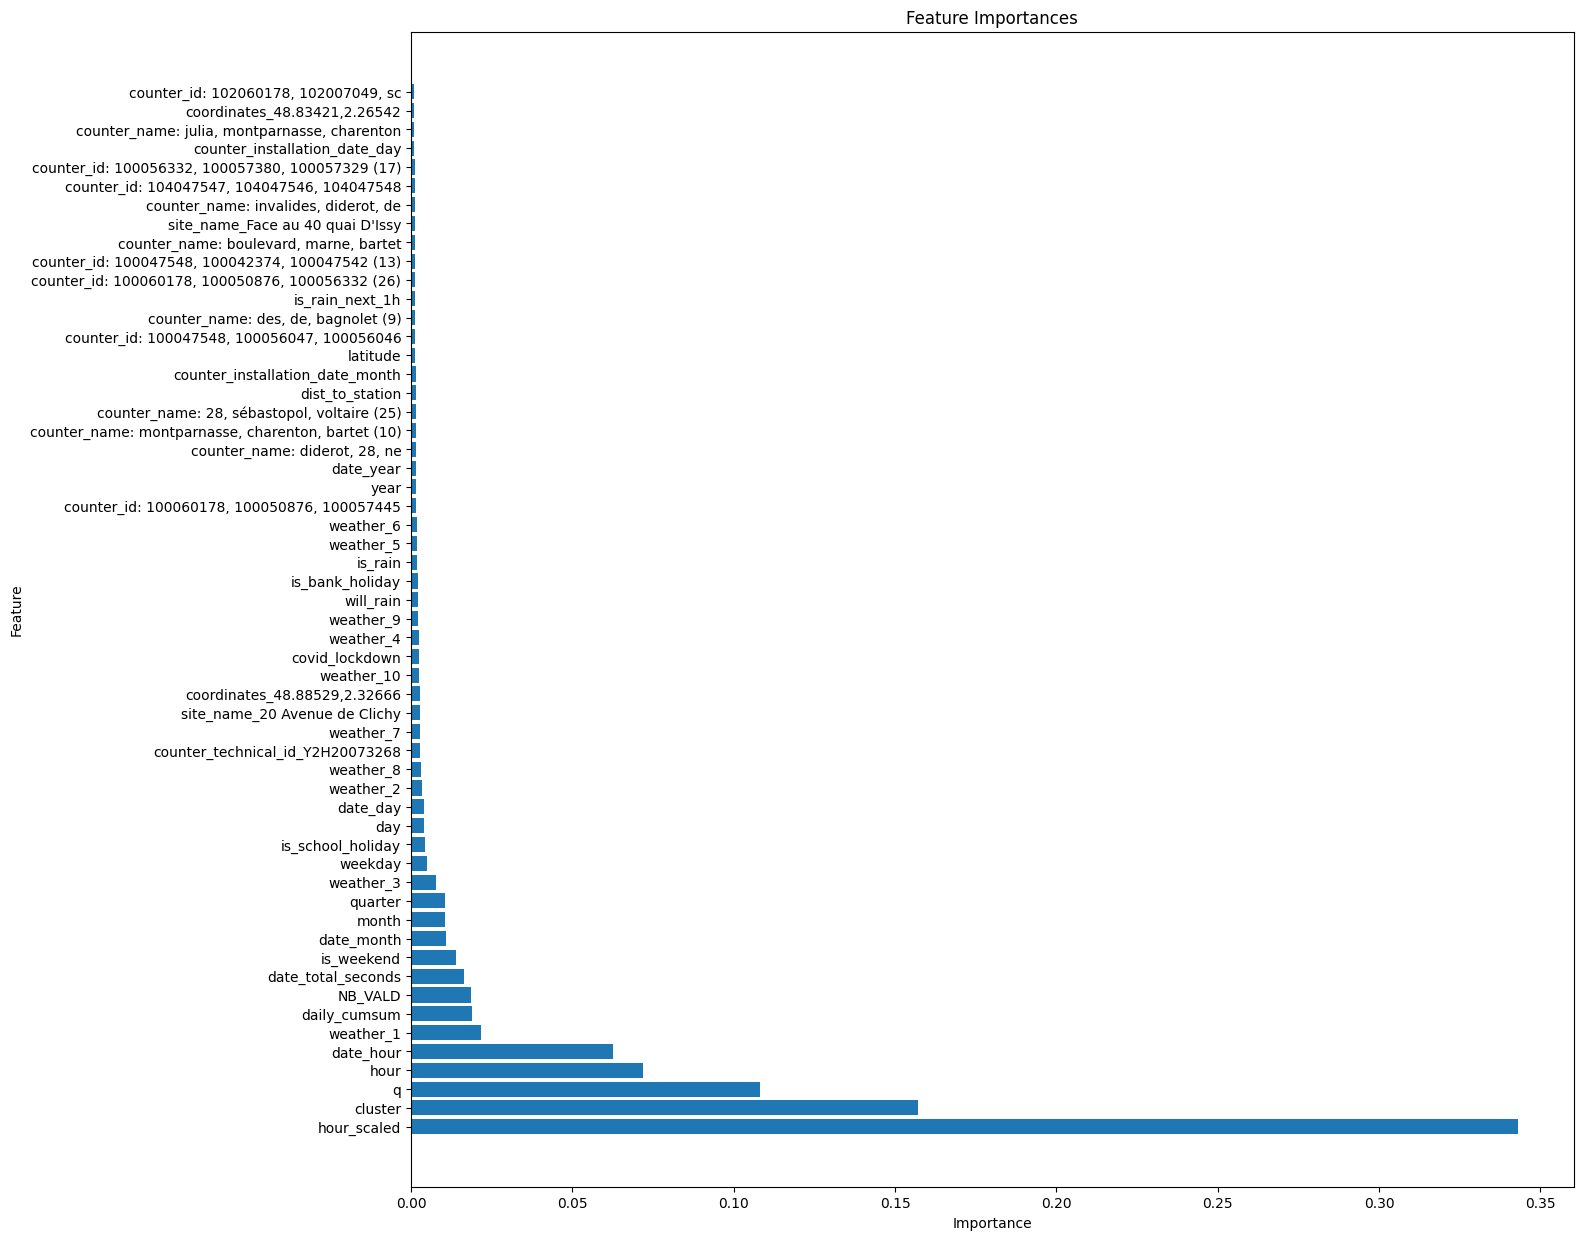

In [204]:
plt.figure(figsize=(15, 15))
plt.barh(
    feature_importance_df[feature_importance_df["Importance"] > 0.001]["Feature"],
    feature_importance_df[feature_importance_df["Importance"] > 0.001]["Importance"],
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

# Export

In [205]:
pd.DataFrame(y_pred, columns=["log_bike_count"]).reset_index().rename(
    columns={"index": "Id"}
).to_csv("/Users/pierrehaas/bike_counters/predictions.csv", index=False)